# Personal Credit Scoring

In this week, we are going to predict credit card default status of customers. For this purpose, we are going to use a modified version (by me!!) of the dataset of Yeh and Lien (2009). You can download the original dataset from : http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

We are going to use supervised learning as we have access to labeled data. 

## What are we going to do?

* We are going to use supervised learning in order to predict customers who are going to default on their payments for next month, based on their previous patterns (6 months).
* We are going to study and preprocess data and generate new features.
* We are going to evaluate the success of different approaches that we use.
* We are going to tune the classifier that we use and do feature selection.

First, we read training and testing data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_train = pd.read_excel('../data/Credit_Scoring_train.xls')
df_test = pd.read_excel('../data/Credit_Scoring_test.xls')

print(df_train.head())

for i in df_train.columns:
    print(i)

    CUSTOMER_ID  LIMIT_BAL     SEX   EDUCATION MARRIAGE   AGE  PAYMENT_1  \
0  461090387729    10000.0    Male         NaN  Married  43.0         -1   
1  456333788060    10000.0  Female         NaN   Single  24.0         -1   
2  530658128376    10000.0  Female         NaN   Single  21.0          0   
3  546506894510    10000.0    Male         NaN   Single  35.0          3   
4  469501329931    10000.0    Male  Gradschool   Single  47.0          0   

   PAYMENT_2  PAYMENT_3  PAYMENT_4   ...     REMAINING_AMOUNT_4  \
0          0          0          0   ...                      0   
1          0          0          0   ...                   2583   
2          0          0          0   ...                   8099   
3          2          0          0   ...                   8838   
4          0          0         -1   ...                   2640   

   REMAINING_AMOUNT_5  REMAINING_AMOUNT_6  PAYMENT_AMOUNT_1  PAYMENT_AMOUNT_2  \
0                   0                   0              2537

## Data Preparation

You can find the meaning of the columns in data.

* CUSTOMER_ID: Unique ID for each customer.
* LIMIT_BAL: Amount of the credit limit.
* SEX: Gender (Male, Female). 
* EDUCATION: Education (Gradschool, University, Highschool). 
* MARRIAGE: Marital status (Married, Single). 
* AGE: Age (year). 
* PAYMENT_1 - PAYMENT_6: History of past payment delay (1 being September 2005 and 6 being April 2005) in months.
* REMAINING_AMOUNT_1 - REMAINING_AMOUNT_6: Amount owed to bank (1 being September 2005 and 6 being April 2005) 
* PAYMENT_AMOUNT_1 - PAYMENT_AMOUNT_6: Amount of previous payment (1 being September 2005 and 6 being April 2005) 
* default: Target variable, status of default for next month (0 = On time, 1 = Late)


First let us examine numerical columns and see if there are missing values. 

In [2]:
print np.shape(df_train)

print df_train['LIMIT_BAL'].describe()
print df_train['AGE'].describe()
print df_train[[i for i in df_train.columns if 'REMAINING_AMOUNT' in i]].describe()
print df_train[[i for i in df_train.columns if 'PAYMENT' in i]].describe()

(19800, 25)
count      19797.000000
mean      167964.220842
std       129539.225759
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64
count    19781.000000
mean        35.540064
std          9.220722
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64
       REMAINING_AMOUNT_1  REMAINING_AMOUNT_2  REMAINING_AMOUNT_3  \
count        19800.000000        19800.000000        1.980000e+04   
mean         51265.968131        49428.558232        4.719719e+04   
std          73465.137845        71323.105122        6.942574e+04   
min        -165580.000000       -33350.000000       -1.572640e+05   
25%           3605.750000         3066.250000        2.694750e+03   
50%          22357.500000        21394.000000        2.010050e+04   
75%          66868.750000        64229.500000        6.039650e+04   
max       

We can see that the balance limit ('LIMIT_BAL') and age columns are missing for some customer. We can choose to delete the customers or impute a value instead of the missing information. What we do depends on the importance of the feature and the number of missing values. For age it is more appropriate to replace missing values with the mean or median of the column. For the balance limit we can choose to delete these customers. 

We use scikit-learn in order to impute missing values by using **Imputer** function.

In [3]:
df_train = df_train[df_train['LIMIT_BAL'] >0]

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=1)

df_train['AGE'] = imp.fit_transform(df_train['AGE']).transpose()

print(np.shape(df_train))
print(df_train['AGE'].describe())
print df_train['LIMIT_BAL'].describe()

(19797, 25)
count    19797.000000
mean        35.539375
std          9.216861
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64
count      19797.000000
mean      167964.220842
std       129539.225759
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64


/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Now let us examine other columns, which does not feature numbers.

In [4]:
print df_train['SEX'].describe()
print df_train['EDUCATION'].describe()
print df_train['MARRIAGE'].describe()

count      19797
unique         2
top       Female
freq       11962
Name: SEX, dtype: object
count          19517
unique             3
top       University
freq            9235
Name: EDUCATION, dtype: object
count      19555
unique         2
top       Single
freq       10570
Name: MARRIAGE, dtype: object


Columns for education and marriage have some missing values. It is possible that the lack of information is important. In addition to that, the number of customers with missing values is not small. Instead of using mean and median values we have to find another way of dealing with missing values. So we have to transform these columns by keeping this information and by producing features without missing values.

A way to do that is add a flag to missing values. We replace missing values with this flag (for example 'MISSING').

In [5]:
df_train['EDUCATION'].fillna('MISSING_EDU', inplace = True)
df_train['MARRIAGE'].fillna('MISSING_MAR', inplace = True)

print(df_train['EDUCATION'].head())

0    MISSING_EDU
1    MISSING_EDU
2    MISSING_EDU
3    MISSING_EDU
4     Gradschool
Name: EDUCATION, dtype: object


So, now a person can be married, single, or unknown (MISSING_MAR) to the company. However, we still cannot use this column for our prediction. In order to do that, we must replace the values with numbers. 

An important mistake here would be to give numbers to each marital status (0 = married, 1 = single, 2 = missing), especially if the number of possible values is greater than 2. The numbers here are mere representations. In order to use this information, we have to create dummy variables, using **get_dummies** in pandas. 

In [6]:
df_education = df_train[ 'EDUCATION' ]
print(df_education.head())
df_education = pd.get_dummies(df_education)

print(df_education.head())

df_marriage = df_train[ 'MARRIAGE' ]
print(df_marriage.head())
df_marriage = pd.get_dummies(df_marriage)

print(df_marriage.head())

0    MISSING_EDU
1    MISSING_EDU
2    MISSING_EDU
3    MISSING_EDU
4     Gradschool
Name: EDUCATION, dtype: object
   Gradschool  Highschool  MISSING_EDU  University
0         0.0         0.0          1.0         0.0
1         0.0         0.0          1.0         0.0
2         0.0         0.0          1.0         0.0
3         0.0         0.0          1.0         0.0
4         1.0         0.0          0.0         0.0
0    Married
1     Single
2     Single
3     Single
4     Single
Name: MARRIAGE, dtype: object
   MISSING_MAR  Married  Single
0          0.0      1.0     0.0
1          0.0      0.0     1.0
2          0.0      0.0     1.0
3          0.0      0.0     1.0
4          0.0      0.0     1.0


Next, we create the final dataframe for the prediction. We drop columns on education and marital status and add new columns that we created.

In [7]:
df_train.drop(['CUSTOMER_ID', 'EDUCATION', 'MARRIAGE'] , axis=1, inplace=True)

df_train = pd.concat([df_train, df_education, df_marriage], axis=1)

print(df_train.head())

   LIMIT_BAL     SEX   AGE  PAYMENT_1  PAYMENT_2  PAYMENT_3  PAYMENT_4  \
0    10000.0    Male  43.0         -1          0          0          0   
1    10000.0  Female  24.0         -1          0          0          0   
2    10000.0  Female  21.0          0          0          0          0   
3    10000.0    Male  35.0          3          2          0          0   
4    10000.0    Male  47.0          0          0          0         -1   

   PAYMENT_5  PAYMENT_6  REMAINING_AMOUNT_1   ...    PAYMENT_AMOUNT_5  \
0         -1         -1               17560   ...                   0   
1          0         -1                5742   ...                   0   
2          0         -1                7691   ...                   0   
3          0         -1               10281   ...                   0   
4         -1         -1                7968   ...                 738   

   PAYMENT_AMOUNT_6  default  Gradschool  Highschool  MISSING_EDU  University  \
0                 0        1       

We do the same thing for the sex column (in a different way).

In [8]:
df_train['MALE'] = (df_train.SEX == 'Male')*1
df_train['FEMALE'] = (df_train.SEX == 'Female')*1
df_train.drop('SEX', axis=1, inplace=True)

Finally, we are going to create some more features. Each customer has a balance limit for their credit card and it might carry some information. As someone gets older, probably the limit will also increase. So in addition to these features, let us create a new feature called 'LIMIT_PER_AGE' by dividing the balance to age. Among two customers with the same balance, a younger one might be more lucrative, earning more money.

In addition to that, the relation between the amount you owe to the bank and your limit can also be important. Among two people owing the same amount, the one with higher limit (or higher income) must be a safer customer. Therefore, we divide REMAINING_AMOUNT_1 to LIMIT_BAL.

In [9]:
df_train['LIMIT_PER_AGE'] = df_train['LIMIT_BAL'] / df_train['AGE']
df_train['RELATIVE_REMAINING_AMOUNT'] = df_train['REMAINING_AMOUNT_1'] / df_train['LIMIT_BAL']

Next we also create test data using the same steps.

In [11]:
df_test = pd.read_excel('../data/Credit_Scoring_test.xls')
df_test['AGE'] = imp.transform(df_test['AGE']).transpose()

df_test['EDUCATION'].fillna('MISSING_EDU', inplace = True)
df_test['MARRIAGE'].fillna('MISSING_MAR', inplace = True)

df_education = df_test[ 'EDUCATION' ]
df_education = pd.get_dummies(df_education)

df_marriage = df_test[ 'MARRIAGE' ]
df_marriage = pd.get_dummies(df_marriage)

df_test.drop(['CUSTOMER_ID', 'EDUCATION', 'MARRIAGE'] , axis=1, inplace=True)

df_test = pd.concat([df_test, df_education, df_marriage], axis=1)

df_test['LIMIT_PER_AGE'] = df_test['LIMIT_BAL'] / df_test['AGE']
df_test['RELATIVE_REMAINING_AMOUNT'] = df_test['REMAINING_AMOUNT_1'] / df_test['LIMIT_BAL']

df_test['MALE'] = (df_test.SEX == 'Male')*1
df_test['FEMALE'] = (df_test.SEX == 'Female')*1
df_test.drop('SEX', axis=1, inplace=True)

df_test = df_test[df_train.columns]

/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# Classification and Evaluation

We try several classifiers to study credit scores. First, we separate the target values in the dataframes.

In [12]:
y_train = df_train.default
y_test = df_test.default

df_train.drop('default', axis=1, inplace=True)
df_test.drop('default', axis=1, inplace=True)

Let us use three classifiers. I choose decision trees, random forests and gradient boosting. You can choose different classifiers such as logistic regression. We create and train these classifiers with default arguments.

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
dt = DecisionTreeClassifier()
dt.fit(df_train,y_train)

rf = RandomForestClassifier()
rf.fit(df_train,y_train)

gbc = GradientBoostingClassifier()
gbc.fit(df_train,y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Now we can test our results.

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

print 'Decision Tree'
print 'Accuracy'
print(accuracy_score(y_test, dt.predict(df_test)))
print 'AUC score'
print(roc_auc_score(y_test, dt.predict_proba(df_test)[:,1]))
print 'Confusion Matrix'
print(confusion_matrix(y_test, dt.predict(df_test)))

print 'Random Forest'
print 'Accuracy'
print(accuracy_score(y_test, rf.predict(df_test)))
print 'AUC score'
print(roc_auc_score(y_test, rf.predict_proba(df_test)[:,1]))
print 'Confusion Matrix'
print(confusion_matrix(y_test, rf.predict(df_test)))

print 'Gradient Boosting'
print 'Accuracy'
print(accuracy_score(y_test, gbc.predict(df_test)))
print 'AUC score'
print(roc_auc_score(y_test, gbc.predict_proba(df_test)[:,1]))
print 'Confusion Matrix'
print(confusion_matrix(y_test, gbc.predict(df_test)))

Decision Tree
Accuracy
0.720490196078
AUC score
0.612394139768
Confusion Matrix
[[6396 1505]
 [1346  953]]
Random Forest
Accuracy
0.800490196078
AUC score
0.729629204908
Confusion Matrix
[[7464  437]
 [1598  701]]
Gradient Boosting
Accuracy
0.817549019608
AUC score
0.776731781767
Confusion Matrix
[[7488  413]
 [1448  851]]


Instead of writing the same piece of code for all classifiers, can you write a function for evaluating classifiers?

In [15]:
def evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    print clf
    print 'Accuracy'
    print(accuracy_score(y_test, y_pred))
    print 'AUC score'
    print(roc_auc_score(y_test, y_pred_proba[:,1]))
    print 'Confusion Matrix'
    print(confusion_matrix(y_test, y_pred))

dt = DecisionTreeClassifier()
evaluate(dt, df_train, y_train, df_test, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy
0.719803921569
AUC score
0.611987437625
Confusion Matrix
[[6389 1512]
 [1346  953]]


Now let us compare three methods by using ROC curve. Which approach is better?

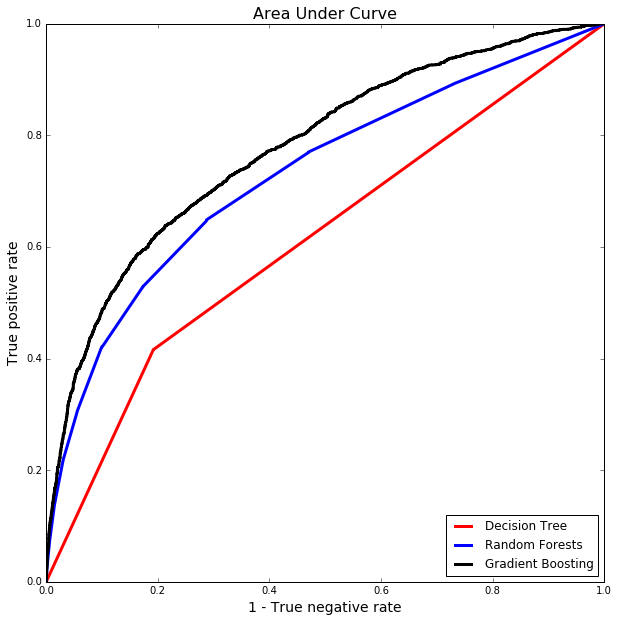

In [16]:
a_dt , b_dt, c_dt = roc_curve(y_test,dt.predict_proba(df_test)[:,1])
a_rf , b_rf, c_rf = roc_curve(y_test,rf.predict_proba(df_test)[:,1])
a_gbc , b_gbc, c_gbc = roc_curve(y_test,gbc.predict_proba(df_test)[:,1])

plt.figure(figsize=(10,10))

plt.plot(a_dt,b_dt, c='red', label = 'Decision Tree', linewidth = 3)
plt.plot(a_rf,b_rf, c='blue', label = 'Random Forests', linewidth = 3)
plt.plot(a_gbc,b_gbc, c='black', label = 'Gradient Boosting', linewidth = 3)
plt.title('Area Under Curve', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('1 - True negative rate', fontsize = 14)

plt.legend(loc = 4)
plt.show()

Area under curve provies information on the compromise between true positive rate (correctly classified defaulting customers) and the true negative rate (correctly classified non-defaulting customers). In the figure above if the true positive rate is 0, then the true negative rate is 1 (all customers are classified as non-default). In other words, if we classify every customer as non-defaulting, we correctly guess all non-defaulting customers, but we miss all of the defaulting customers. In the other extreme if the true positive rate is 1, the true negative rate is 0 (all customers are classified as default). For the gradient boosting if we guess 40% of defaulting customers (true positive rate is 0.4) we miss approximately 5-10% of non-defaulting customers (1 - true negative rate is around 0.05 and 0.1). The same value goes to more than 10% for random forests and to almost 20% for decision trees.

# Fine Tuning

If you visit the corresponding web page for the classifiers that we use, you can see there are several parameters to play with. We are going to change the number of estimators and see how our method perform with different number of estimators for training and testing data. We use roc_auc_score to select the best approach.

First, we want to select **n_estimators** in Gradient Boosting. We train the method using 1000 estimators.

In [17]:
n_estimators = 2000
gbc = GradientBoostingClassifier(n_estimators=n_estimators, verbose = 1)
gbc.fit(df_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0137           50.09s
         2           0.9862           51.38s
         3           0.9651           55.31s
         4           0.9482           55.02s
         5           0.9347           53.82s
         6           0.9229           53.37s
         7           0.9127           53.43s
         8           0.9040           54.04s
         9           0.8969           54.68s
        10           0.8905           55.08s
        20           0.8583           53.38s
        30           0.8446           52.30s
        40           0.8352           50.81s
        50           0.8286           49.90s
        60           0.8237           49.14s
        70           0.8191           48.17s
        80           0.8155           47.67s
        90           0.8120           47.37s
       100           0.8091           46.78s
       200           0.7814           42.58s
       300           0.7564           39.92s
       40

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

At each iteration, we build an additional decision tree. Let us see how roc_auc_score changes with each iteration. We have to use **staged_predict_proba** function to obtain results for each iteration. We do it for training and testing data.

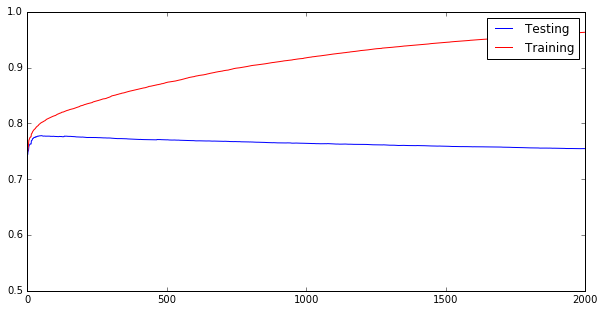

In [18]:
score = np.zeros(n_estimators)
for i, y_pred in enumerate(gbc.staged_predict_proba(df_test)):
    score[i] = roc_auc_score(y_test, y_pred[:,1])

score_train = np.zeros(n_estimators)
for i, y_pred in enumerate(gbc.staged_predict_proba(df_train)):
    score_train[i] = roc_auc_score(y_train, y_pred[:,1])
    
plt.figure(figsize=(10,5))
plt.plot(score, c= 'blue', label = 'Testing')
plt.plot(score_train, c= 'red', label = 'Training')
plt.legend()
plt.ylim((0.5,1))
plt.show()

We can see that we obtain the best results for around 30 estimators. As the number of estimators increases roc_auc_score goes down for the testing data. However, it increases for the training data. As the number of estimators increases, we tend to overfit.

To carry a similar study for random forests, we have to use a different approach. Random forests are not iterative like gradient boosting method. So it does not have staged_predict functionality. For this reason, we have to use other means of parameter selection. Luckily there is Grid Search module, which helps us select the best parameters for the classifier.

In [19]:
from sklearn.grid_search import GridSearchCV
from time import time 
# specify parameters and distributions to sample from
parameters = {"max_depth": [3, 5, 10],
              "min_samples_leaf": [20, 50, 100],
              "n_estimators": [50, 100, 200]}

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=parameters, scoring = 'roc_auc')
start = time()
grid_search.fit(df_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))

GridSearchCV took 119.51 seconds for 27 candidate parameter settings.


In [20]:
print grid_search.best_estimator_
print grid_search.best_score_

print roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(df_test)[:,1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.772073233204
0.77021785857


We can see that, we improved the performance of random forest by tuning the parameters. Can we also do it for decision trees?

In [21]:
dt = DecisionTreeClassifier(min_samples_leaf=50)
dt.fit(df_train,y_train)

print 'Decision Tree'
print 'Accuracy'
print(accuracy_score(y_test, dt.predict(df_test)))
print 'AUC score'
print(roc_auc_score(y_test, dt.predict_proba(df_test)[:,1]))
print 'Confusion Matrix'
print(confusion_matrix(y_test, dt.predict(df_test)))

from sklearn.tree import export_graphviz

export_graphviz(dt, out_file='Tree.dot', feature_names= df_train.columns)

Decision Tree
Accuracy
0.812843137255
AUC score
0.74375766575
Confusion Matrix
[[7421  480]
 [1429  870]]


You can transform dot file into a tree figure by using graphviz or do it online at: https://stamm-wilbrandt.de/GraphvizFiddle/

# Feature Importances and Feature Selection

Between gradient boosting, random forests and decision trees, gradient boosting perform better than others. Now, we are able to predict future customers and their risk status. It is now time to study the factors affecting the risk status of customers. For this purpose, we use **feature\_importances\_** attribute of the classifier. We also would like to visualize the importance of features.

[ 0.02061738  0.04105157  0.02484027  0.01235742  0.01173892  0.0107968
  0.00925396  0.00894888  0.08011296  0.06294906  0.06152654  0.04812284
  0.05990161  0.0583218   0.05078591  0.05341421  0.05131851  0.04610154
  0.04062615  0.05055473  0.00326272  0.00381996  0.00177522  0.00271514
  0.00394715  0.0026797   0.00347021  0.00211083  0.00213409  0.07511726
  0.09562662]
                           Importance
LIMIT_BAL                    0.020617
AGE                          0.041052
PAYMENT_1                    0.024840
PAYMENT_2                    0.012357
PAYMENT_3                    0.011739
PAYMENT_4                    0.010797
PAYMENT_5                    0.009254
PAYMENT_6                    0.008949
REMAINING_AMOUNT_1           0.080113
REMAINING_AMOUNT_2           0.062949
REMAINING_AMOUNT_3           0.061527
REMAINING_AMOUNT_4           0.048123
REMAINING_AMOUNT_5           0.059902
REMAINING_AMOUNT_6           0.058322
PAYMENT_AMOUNT_1             0.050786
PAYMENT_AMOUNT

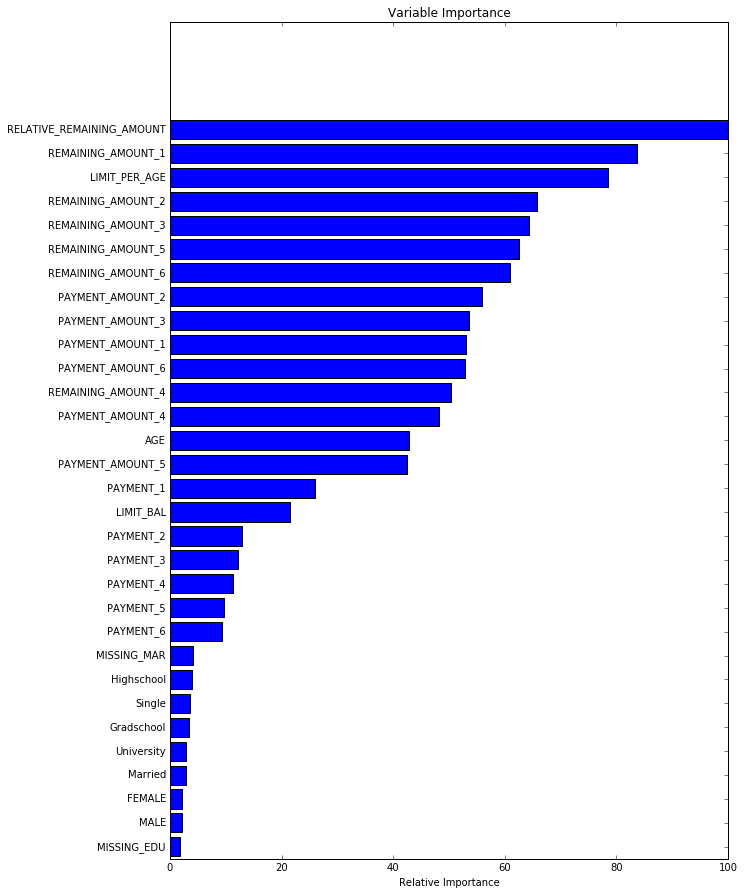

In [21]:
# Plot feature importance
feature_importance = gbc.feature_importances_

print(feature_importance)

df_features = pd.DataFrame(feature_importance)
df_features.columns = ['Importance']
df_features.index = df_train.columns
print(df_features)
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

We can see that almost half of the features are not very useful for prediction. However, the features that we created seem to be quite useful. Let us see whether we can eliminate these features and still perform reasonably close. again scikit-learn has feature elimination modules for this purpose. We are going to use recursive feature elimination (**RFE**).

In [23]:
from sklearn.feature_selection import RFE



clf = GradientBoostingClassifier(n_estimators = 30)
selector = RFE(clf, n_features_to_select= 10, step=2)
selector = selector.fit(df_train, y_train)
print(selector.support_)
print(df_train.columns[selector.support_])

[False False  True False  True  True  True  True  True False False False
 False False  True  True False False False False False False False False
 False False False False False  True  True]
Index([                u'PAYMENT_1',                 u'PAYMENT_3',
                       u'PAYMENT_4',                 u'PAYMENT_5',
                       u'PAYMENT_6',        u'REMAINING_AMOUNT_1',
                u'PAYMENT_AMOUNT_1',          u'PAYMENT_AMOUNT_2',
                   u'LIMIT_PER_AGE', u'RELATIVE_REMAINING_AMOUNT'],
      dtype='object')


We know which 10 features are the most informative. Let us carry the analysis using these features.

In [24]:
df_train_rfe = selector.transform(df_train)
df_test_rfe = selector.transform(df_test)

evaluate(clf, df_train_rfe, y_train, df_test_rfe, y_test)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Accuracy
0.818137254902
AUC score
0.773628678824
Confusion Matrix
[[7518  383]
 [1472  827]]


We almost obtain the same results using only 10 features. Feature selection is very useful when dealing with a large number of attributes. It might even improve your results.

# Scaling (Optional)

For some algorithms it is necessary to scale data in order to get meaningful results (such as linear regression). In that case we can use **StandardScaler** function of preprocessing module. However tree based algorithms do not require this step. 

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train_scaled = scaler.fit_transform(df_train)

df_test_scaled = scaler.transform(df_test)

# References
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.